## Loading up packages

In [1]:
import sys
sys.path.append('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/tools/')

In [2]:
# import plastid
# data structure for mapping read alignments to genomic positions
from plastid import BAMGenomeArray, VariableFivePrimeMapFactory, \
                        GTF2_TranscriptAssembler, GFF3_TranscriptAssembler, \
                        Transcript, ThreePrimeMapFactory
import numpy as np
import os
from Bio import SeqIO
import numpy
import math
import pandas as pd
from scipy import stats
from scipy.stats import kstwo
import keegan_analysis_tools as kat
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
import csv
from scipy.sparse.linalg import lsqr

In [4]:
# Define the path to our Bam files
data_path = '/home/keeganfl/Desktop/Work_Fall_2021/genomes_&_samples/dmel/'
csv_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/position_counts/dmel/'
save_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/KS_stats/dmel/'
gtf_name = 'Drosophila_melanogaster.BDGP6.32.103.gtf'
mutation = 'Fmr1'
samp_num = '3'
if os.path.isfile(save_path + "ks_table_" + samp_num + ".csv") == True:
    pre_load = True
else:
    pre_load = False

## Loading up the data files 

In [5]:
# load the transcript annotations from the GTF file.
# GTF2_TranscriptAssembler returns an iterator, so here we convert it to a list.
transcripts = list(GTF2_TranscriptAssembler(open(data_path + gtf_name),return_type=Transcript))

In [7]:
# Remove non-protein coding transcripts from transcripts list. 
protein_coding = []
for transcript in transcripts:
    if transcript.attr['gene_biotype'] == 'protein_coding':
        protein_coding.append(transcript)

In [8]:
# clear up some memory by deleting original transcript list
transcripts.clear()

## Loading up the csv file.

In [6]:
data_mutant = kat.load_count_positions(mutation+"_RPF_"+samp_num+"_counts.csv",csv_path)
data_control = kat.load_count_positions("control_RPF_"+ samp_num +"_counts.csv",csv_path)

## Running the KL divergence on some basic data. 

In [46]:
my_transcript, tr_m, tr_c, index = kat.find_transcripts("lost", protein_coding, data_mutant, data_control, )
position = np.array(list(range(len(tr_m))))

In [47]:
smoothed_vec_m, cumul_m = kat.get_smoothed_vector(position, tr_m+0.00000000001)
smoothed_vec_c, cumul_c = kat.get_smoothed_vector(position, tr_c+0.00000000001)

In [48]:
for d, i in zip(smoothed_vec_m, list(range(len(smoothed_vec_m)))):
    if d < 0:
        smoothed_vec_m[i] = 0.000000000000000000001

In [49]:
for d, i in zip(smoothed_vec_c, list(range(len(smoothed_vec_c)))):
    if d < 0:
        smoothed_vec_c[i] = 0.000000000000000000001

In [50]:
def KL(a, b):
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)

    return np.sum(np.where(a != 0, a * np.log(a / b), 0))


values1 = [1.346112,1.337432,1.246655]
values2 = [1.033836,1.082015,1.117323]

print(KL(values1, values2))

0.7752796240788413


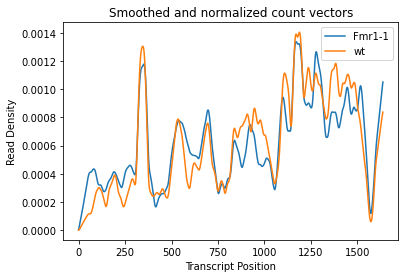

In [59]:
plt.plot(smoothed_vec_m, label = "Fmr1-1")
#plt.plot(my_vec_mutant/sum(my_vec_mutant))
plt.plot(smoothed_vec_c, label = "wt")
plt.ylabel("Read Density")
plt.xlabel("Transcript Position")
plt.title("Smoothed and normalized count vectors")
plt.legend()

In [52]:
KL(smoothed_vec_m, smoothed_vec_c)

0.03883714237753458

In [53]:
stats.entropy(smoothed_vec_m, smoothed_vec_c)

0.03899974873379677

Hmmmm, I do not know why lowess smoothing occasionally returns negative values. The negative values are very low and very rare but they do occur. 

In [56]:
for i in smoothed_vec_m:
    if i == 0.000000000000000000001:
        print(i)

1e-21
